## $\textit{Comparisons}$

In [6]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_theme()

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

In [7]:
import glob
import pickle
import pandas as pd
import os

pattern = 'gmm_*_mfcc_*_*_*.pkl'
files = glob.glob(pattern)
data_rows = []

for file in files:
    
    base_name = os.path.basename(file)
    parts = base_name.split('_')
    gender = parts[1]         
    mfcc = parts[3]           
    window_size = parts[4]  
    components = parts[5].split('.')[0] 
    if 'D' in parts[-1]:
        continue
    with open(file, 'rb') as f:
        data = pickle.load(f)

    # Append the information as a row in the list
    data_rows.append({'gender': gender, 'mfcc': mfcc, 'window_size': window_size, 'components': components, 'model': data})

# Create a DataFrame from the list of rows
models = pd.DataFrame(data_rows)

/home/gullino18/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## $\textit{Acc vs MFFC}$

In [8]:

def getDatasets(mfcc_coeff_amount, window_length):

    arr_mfcc = []
    arr_delta = []
    arr_delta_delta = []
    
    if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

        aux = []

        for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
            for filename in filenames:
                if filename.endswith(".wav"):
                    filepath = dirpath + "/" + filename
                    aux.append({"file": filepath, "gender": "females" if "females" in dirpath else "males"})

        df = pd.DataFrame(aux)

        df["mfcc"] = pd.Series(name="mfcc", dtype=object)
        df["delta"] = pd.Series(name="delta", dtype=object)
        df["delta_delta"] = pd.Series(name="delta_delta", dtype=object)

        for i in range(len(df)):
            mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
            for i, coeffs in enumerate(mfcc_coeffs):
                if np.linalg.norm(coeffs) < 1:
                    mfcc_coeffs.pop(i)

            arr_mfcc.append(mfcc_coeffs.T)
            arr_delta.append(librosa.feature.delta(mfcc_coeffs.T))
            arr_delta_delta.append(librosa.feature.delta(mfcc_coeffs.T, order=2))
        df["mfcc"] = arr_mfcc
        df["delta"] = arr_delta
        df["delta_delta"] = arr_delta_delta
        df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
    else:
        print("File Found")
        df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")

    return df

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import pickle


def test(model_male, model_female, df_test):

    predictions = []
    
    scores_gmm = pd.Series(index=df_test.index)

    for index, row in df_test.iterrows():
        score = model_male.score_samples(row["mfcc"]) - model_female.score_samples(row["mfcc"])
        scores_gmm[index] = score.mean()

    for index in df_test.index:
        if scores_gmm[index] > 0:
            predictions.append('males')
        else:
            predictions.append('females')
    
    # Convert predictions to a pandas Series
    predictions = pd.Series(predictions, index=df_test.index)

    # Calculate the accuracy
    accuracy = (predictions == df_test["gender"]).mean()

    # Print the accuracy
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    return accuracy * 100

In [10]:
accs = []
for i, row in models[models.gender == "female"].iterrows():
        print(row["mfcc"], row["components"])
        f = row["model"]
        m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
        dataset = getDatasets(int(row["mfcc"]), 320)
        accs.append((test(m, f, dataset), row["mfcc"], row["components"]))

/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]


12 16
File Found


/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 90.34%
24 10
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 94.83%
24 6
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 88.59%
12 8
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 90.26%
24 24
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 95.14%
12 12
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 89.95%
16 16
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 91.09%
24 16
File Found


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 94.88%
18 18


/tmp/ipykernel_13250/1555333120.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc==row["mfcc"]][models.components==row["components"]].model.iloc[0]
/tmp/ipykernel_13250/2068515347.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm = pd.Series(index=df_test.index)


Accuracy: 90.59%


<Axes: xlabel='2', ylabel='1'>

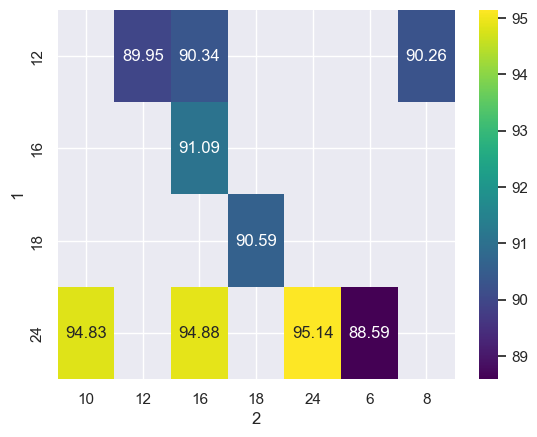

In [12]:
sns.heatmap(pd.DataFrame(accs).pivot(index=1, columns=2, values=0), annot=True, fmt=".2f", cmap="viridis")

In [44]:
mffc_24 = 24
n_comps = 24

dataset = getDatasets(mffc_24, 320)
m = models[models.gender=="male"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model
f = models[models.gender=="female"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model

predictions = []
    
scores_gmm_24 = pd.Series(index=dataset.index)

for index, row in dataset.iterrows():
    score = m.score_samples(row["mfcc"]) - f.score_samples(row["mfcc"])
    scores_gmm_24[index] = score.mean()




File Found


/tmp/ipykernel_13250/143426629.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model
/tmp/ipykernel_13250/143426629.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f = models[models.gender=="female"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model
/tmp/ipykernel_13250/143426629.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm_24 = pd.Series(index=dataset.index)


(-5.0, 5.0)

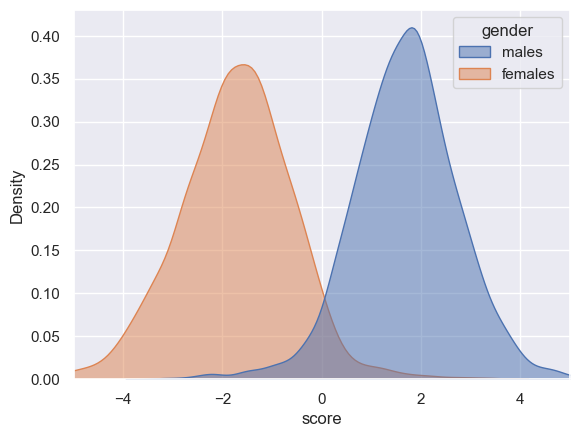

In [45]:
df_scores_24 = pd.DataFrame({'score': scores_gmm_24, 'gender': dataset.gender})
sns.kdeplot(data=df_scores_24, x='score', hue='gender', alpha=0.5, fill=True, common_norm=False)
plt.gca().set_xlim(-5, 5)

In [46]:
mffc_24 = 16
n_comps = 16

dataset = getDatasets(mffc_24, 320)
m = models[models.gender=="male"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model
f = models[models.gender=="female"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model

predictions = []
    
scores_gmm_16 = pd.Series(index=dataset.index)

for index, row in dataset.iterrows():
    score = m.score_samples(row["mfcc"]) - f.score_samples(row["mfcc"])
    scores_gmm_16[index] = score.mean()

File Found


/tmp/ipykernel_13250/1928363368.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model
/tmp/ipykernel_13250/1928363368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f = models[models.gender=="female"][models.mfcc == mffc_24.__str__()][models.components == n_comps.__str__()].iloc[0].model
/tmp/ipykernel_13250/1928363368.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_gmm_16 = pd.Series(index=dataset.index)


(-5.0, 5.0)

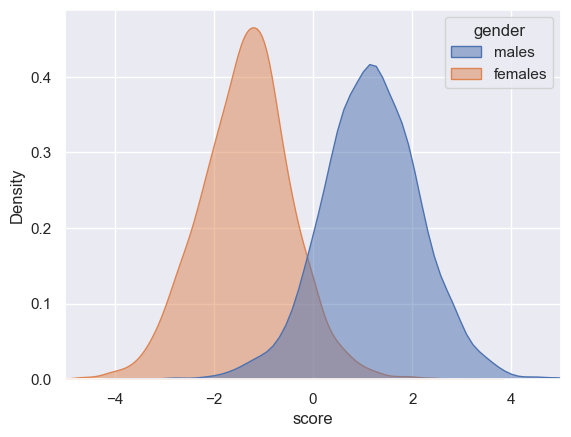

In [47]:
df_scores_16 = pd.DataFrame({'score': scores_gmm_16, 'gender': dataset.gender})
sns.kdeplot(data=df_scores_16, x='score', hue='gender', alpha=0.5, fill=True, common_norm=False)
plt.gca().set_xlim(-5, 5)

In [52]:
import pyaudio
from IPython.display import update_display

Chunk = 1024 * 8
format = pyaudio.paFloat32
channels = 1
rate = 16000

m = models[models.gender=="male"][models.mfcc == "24"][models.components == "24"].iloc[0].model
f = models[models.gender=="female"][models.mfcc == "24"][models.components == "24"].iloc[0].model

/tmp/ipykernel_13250/2690472719.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = models[models.gender=="male"][models.mfcc == "24"][models.components == "24"].iloc[0].model
/tmp/ipykernel_13250/2690472719.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f = models[models.gender=="female"][models.mfcc == "24"][models.components == "24"].iloc[0].model


In [53]:
p = pyaudio.PyAudio()

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    output=True,
    frames_per_buffer=Chunk,
)
result = "male"
display(result, display_id="res")
while True:
    data = stream.read(Chunk)
    data_int = np.frombuffer(data, dtype=np.float32)
    features = librosa.feature.mfcc(y=data_int, sr=16000, n_mfcc=24, window=ss.windows.hamming, win_length=320, hop_length=320//2).T
    
    score_res = m.score_samples(features) - f.score_samples(features)
    score_res = score_res.mean()
    text = f"Is a male speaking?: {score_res > 0}, with a score of {score_res}"
    update_display(text, display_id="res")



'Is a male speaking?: True, with a score of 0.4332224643754614'

KeyboardInterrupt: 